In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra \
                    ,calcular_ks_por_safra,monitorar_variaveis_continuas,obter_importancia_variaveis,calcular_metricas_multiplas


In [2]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")

In [3]:
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [4]:
#verificando o schema
train_selecionada.shape,test_oos.shape

((6568, 43), (1643, 43))

In [5]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [6]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oos = aplicar_imputacao_teste(test_oos,regra_imputacao, dict_mediana, dict_media)

In [7]:
train_selecionada.shape, test_oos.shape

((6568, 43), (1643, 43))

In [8]:
train_selecionada, test_oos, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train_selecionada, test_oos, id_col='id', safra_col='safra', target_col='y')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7853,0.7852,0.3933,0.7182,0.5063,0.3845,0.4137,0.1490
lightgbm,Light Gradient Boosting Machine,0.7779,0.7791,0.4142,0.6740,0.5121,0.3789,0.3983,0.3320


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7700,0.7591,0.4054,0.6452,0.4979,0.3587,0.3749
1,0.7757,0.7871,0.4392,0.6500,0.5242,0.3845,0.3972
2,0.7738,0.7899,0.4631,0.6389,0.5370,0.3923,0.4012
3,0.8042,0.8091,0.4899,0.7300,0.5863,0.4645,0.4804
4,0.7467,0.7509,0.3514,0.5843,0.4388,0.2881,0.3036
5,0.7600,0.7774,0.3649,0.6279,0.4615,0.3208,0.3404
6,0.7924,0.7683,0.4054,0.7407,0.5240,0.4054,0.4356
7,0.7943,0.7881,0.4122,0.7439,0.5304,0.4123,0.4418
8,0.7848,0.7665,0.4257,0.6923,0.5272,0.3980,0.4177


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7852,0.7807,0.3649,0.7397,0.4887,0.3719,0.4092
1,0.7890,0.8196,0.3649,0.7606,0.4932,0.3800,0.4210
2,0.7795,0.7896,0.4362,0.6701,0.5285,0.3928,0.4082
3,0.7947,0.8137,0.4094,0.7531,0.5304,0.4134,0.4448
4,0.7848,0.7632,0.3311,0.7778,0.4645,0.3561,0.4070
5,0.7714,0.7782,0.2973,0.7333,0.4231,0.3110,0.3604
6,0.7829,0.7996,0.3378,0.7576,0.4673,0.3552,0.4009
7,0.7790,0.8091,0.3378,0.7353,0.4630,0.3471,0.3887
8,0.7771,0.7830,0.3446,0.7183,0.4658,0.3463,0.3836


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7681,0.7464,0.3514,0.6667,0.4602,0.3301,0.3575
1,0.7985,0.8250,0.4392,0.7386,0.5508,0.4316,0.4558
2,0.7890,0.7944,0.4765,0.6827,0.5613,0.4281,0.4401
3,0.8099,0.8148,0.4765,0.7634,0.5868,0.4718,0.4939
4,0.7848,0.7585,0.3649,0.7397,0.4887,0.3717,0.4089
5,0.7810,0.7836,0.3649,0.7200,0.4843,0.3636,0.3975
6,0.7752,0.7854,0.3378,0.7143,0.4587,0.3391,0.3769
7,0.7771,0.7790,0.3378,0.7246,0.4608,0.3431,0.3828
8,0.7905,0.7885,0.4257,0.7159,0.5339,0.4098,0.4329


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7681,0.7467,0.3514,0.6667,0.4602,0.3301,0.3575
1,0.7966,0.8268,0.4324,0.7356,0.5447,0.4249,0.4497
2,0.7909,0.7942,0.4698,0.6931,0.5600,0.4294,0.4434
3,0.8042,0.8149,0.4765,0.7396,0.5796,0.4596,0.4785
4,0.7848,0.7605,0.3649,0.7397,0.4887,0.3717,0.4089
5,0.7771,0.7846,0.3514,0.7123,0.4706,0.3494,0.3845
6,0.7752,0.7864,0.3446,0.7083,0.4636,0.3423,0.3779
7,0.7771,0.7804,0.3378,0.7246,0.4608,0.3431,0.3828
8,0.7867,0.7882,0.4122,0.7093,0.5214,0.3963,0.4204


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7826,0.7932,0.3575,0.7389,0.4801,0.3635,0.4026,0.0340
1,Logistic Regression,0.7840,0.7860,0.3892,0.7152,0.5022,0.3800,0.4094,0.0080



🏆 **Modelo Vencedor:** LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0.5, subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0)
✅ Regressão Logística escolhida com AUC: 0.786


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7942,0.8272,0.3832,0.7726,0.5123,0.4000,0.4396


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7748,0.7733,0.3413,0.7085,0.4606,0.3397,0.3759


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7852,0.7961,0.3923,0.7184,0.5075,0.3849,0.4137


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7778,0.7813,0.3715,0.6992,0.4852,0.3600,0.3893


base escorada pycaret
        id   safra  VAR_1    VAR_32      VAR_52      VAR_45      VAR_24  \
0      601  201409   16.0  0.057198  197.970001  298.535004  305.920013   
1     4320  201409   82.0  0.090634  498.959991  298.535004  584.919983   
2     8725  201406  112.0  0.057198  197.970001  298.535004  305.920013   
3     8977  201402    0.0  0.133833   39.990002  159.949997  306.019989   
4     3547  201402   20.0  0.090634  197.970001  298.535004  200.550003   
...    ...     ...    ...       ...         ...         ...         ...   
6563  3540  201405   46.0  0.133833  302.839996  163.919998  235.869995   
6564  2939  201409   21.0  0.020019  197.970001  298.535004  305.920013   
6565  3729  201405   26.0  0.133833  501.190002  394.299988  245.410004   
6566  4807  201402   29.0  0.090634  582.099976  298.535004  305.920013   
6567  9921  201405    0.0  0.133833  197.970001  247.610001  305.920013   

      VAR_72  VAR_44       VAR_17  ...       VAR_54      VAR_76  VAR_64  \
0 

In [9]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]

In [10]:
test_oot.shape

(2527, 43)

In [11]:
#### Escoragem dos Modelos no dataset de OOT ####
#Primeiro vamos aplicar a regra de imputação de missings
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oot = aplicar_imputacao_teste(test_oot,regra_imputacao, dict_mediana, dict_media)


In [12]:
#Agora basta escorar a base oot nos dois modelos

# 🔹 ESCORAGEM DOS MODELOS

# Aplicando LightGBM no conjunto de treino e teste
test_oot_lightgbm = predict_model(tuned_lightgbm, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_lightgbm = test_oot_lightgbm[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6953,0.7103,0.1010,0.6721,0.1756,0.1000,0.1692


In [13]:
test_oot_regressao = predict_model(tuned_lr, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_regressao = test_oot_regressao[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6953,0.7100,0.1084,0.6567,0.1860,0.1045,0.1700


In [14]:
train_lightgbm_escorado.head()

,id,safra,y,score_1,score_0
0,601,201409,1,0.3684,0.6316
1,4320,201409,1,0.6189,0.3811
2,8725,201406,1,0.7121,0.2879
3,8977,201402,0,0.0935,0.9065
4,3547,201402,0,0.1262,0.8738


In [15]:
test_oot_regressao.head()

,id,safra,y,score_0,score_1
0,4,201412,0,0.7640,0.2360
1,13,201411,1,0.7559,0.2441
2,15,201412,0,0.6627,0.3373
3,17,201412,0,0.3359,0.6641
4,20,201411,0,0.8544,0.1456


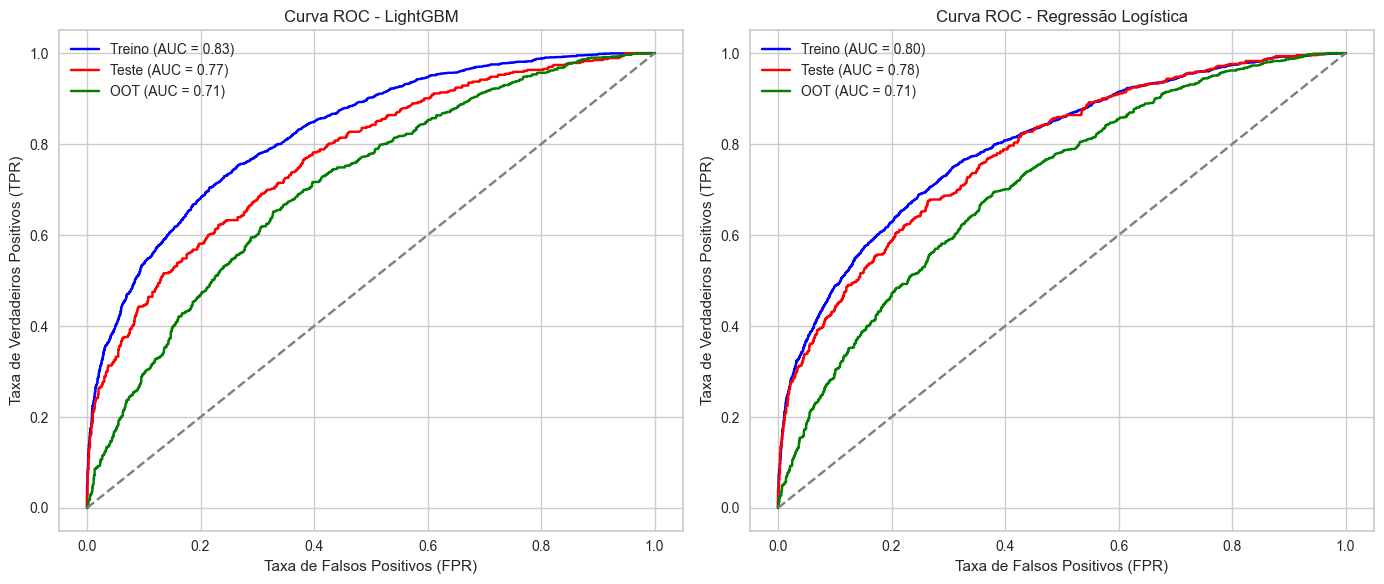

In [16]:
#1. Curva ROC (Receiver Operating Characteristic)
#Mostra a relação entre Taxa de Verdadeiros Positivos (TPR - Sensibilidade) e Taxa de Falsos Positivos (FPR).
#Quanto mais próxima a curva estiver do canto superior esquerdo, melhor o modelo.
#A métrica principal associada é a AUC-ROC (Área sob a Curva ROC), que indica a capacidade do modelo em distinguir classes.
#Usar com objetivo for avaliar o quão bem o modelo separa as classes, independentemente da distribuição dos dados.

plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

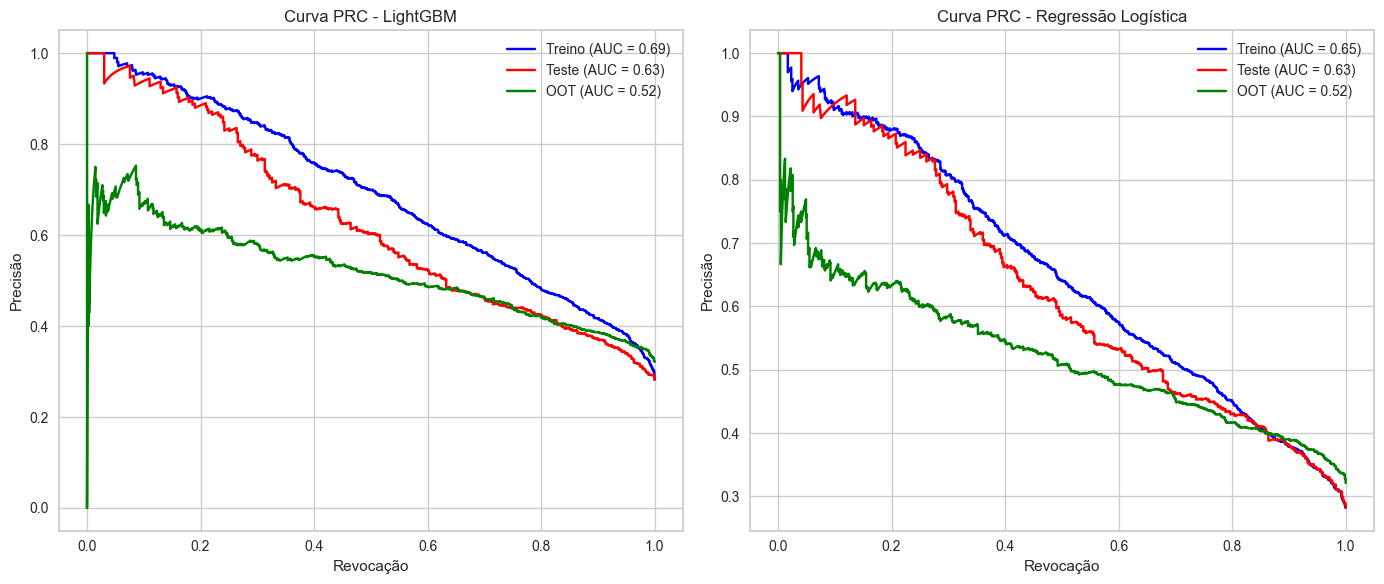

In [17]:
#2. Curva PRC (Precision-Recall Curve)
#Mostra a relação entre Precisão (Precision) e Revocação (Recall - Sensibilidade).
#Útil quando a classe positiva é rara (dados desbalanceados).
#A métrica associada é a AUC-PR, que mede a área sob essa curva.
#Se houver um grande desbalanceamento entre as classes (por exemplo, detecção de fraudes, doenças raras).

plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

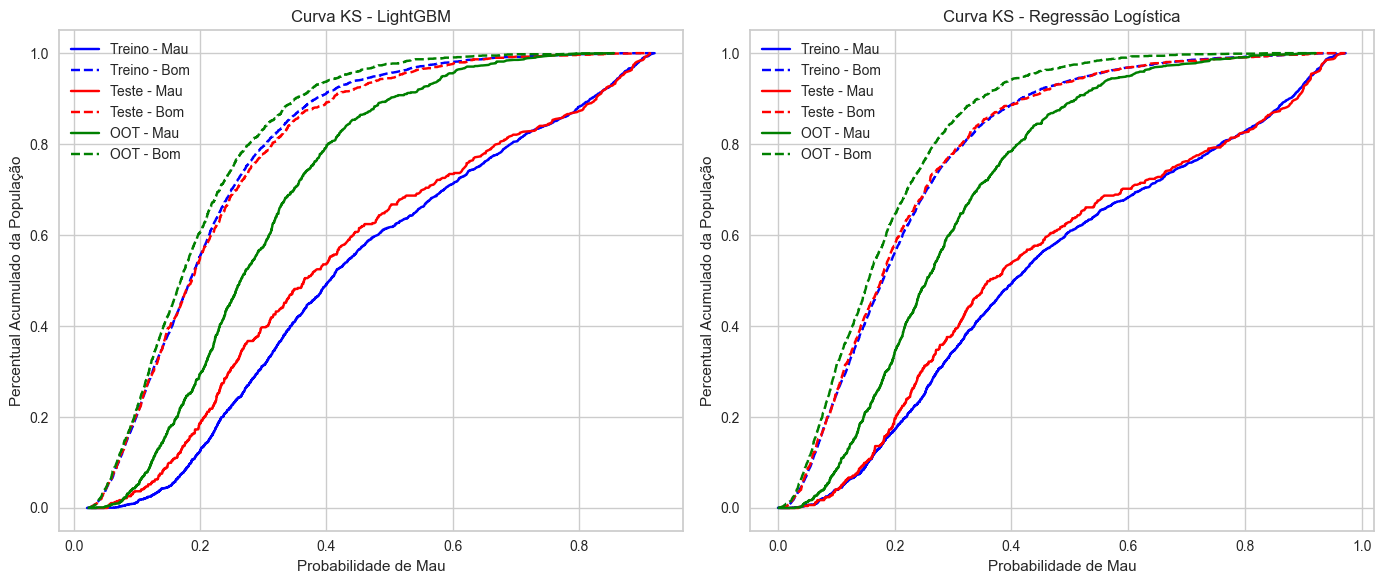

In [18]:
#3. Curva KS (Kolmogorov-Smirnov Curve)
#Mede a diferença máxima entre as distribuições cumulativas de positivos e negativos.
#Quanto maior o valor de KS, melhor a separação do modelo.
#Muito utilizada em modelos de risco de crédito e em cenários onde se quer saber o ponto de máxima separação entre as classes.

plot_comparacao_ks(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

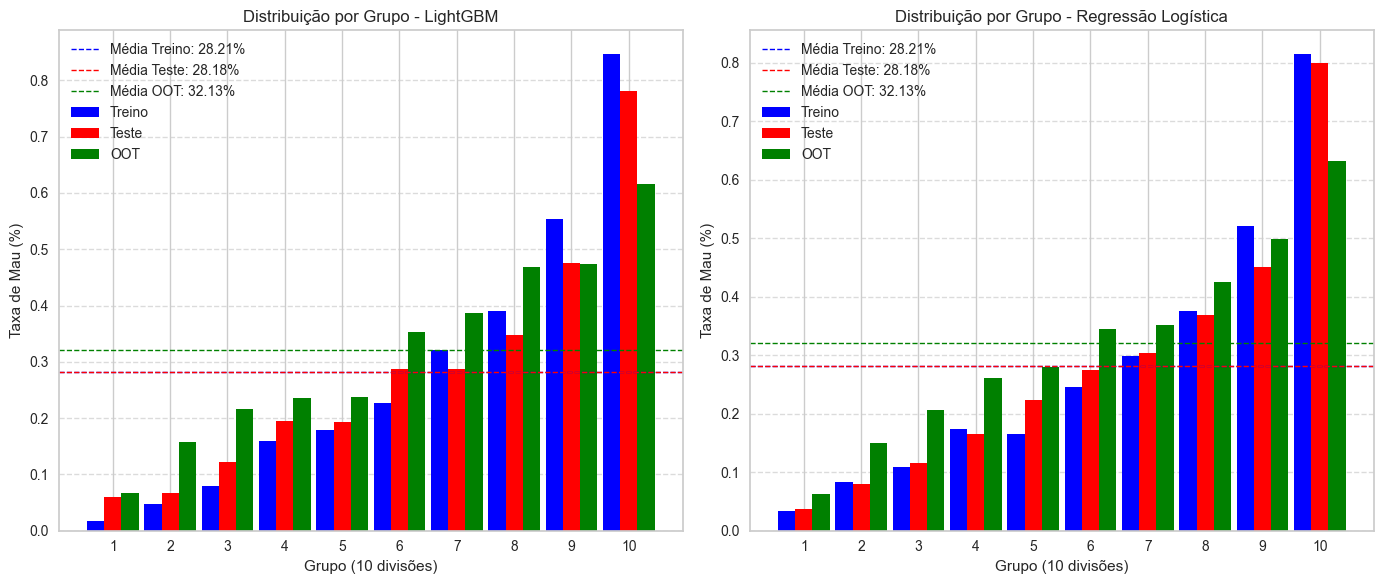

In [19]:
#Verificar se o score está ordenando bem e seguindo uma lógica onde quanto maior a probabilidade de mau, maior o % de maus acumulados
#Ordenamos o score do menor para o maior 
#Criamos faixas discretas e verificamos a quantidade de maus em cada faixa
#Quanto mais ordenadas forem as faixas melhor
plot_comparacao_decil(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [20]:
tabela = gerar_tabela_avaliacao(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [21]:
tabela['nome_dataframe'].unique().tolist()

['Train LightGBM',
 'Test LightGBM',
 'Train Regressão',
 'Test Regressão',
 'OOT LightGBM',
 'OOT Regressão']

In [22]:
tabela[tabela['nome_dataframe']=="OOT LightGBM"].head(10)

,nome_dataframe,quantil,score_0 min,score_0 max,total_casos,total_mau,total_bom,maus_acumulados,% maus acumulados,KS
40,OOT LightGBM,1,0.9223,0.9775,254,17,237,17,2.093596,11.725646
41,OOT LightGBM,2,0.8901,0.9221,255,40,215,57,7.019704,19.335981
42,OOT LightGBM,3,0.8643,0.8898,249,54,195,111,13.669951,24.055997
43,OOT LightGBM,4,0.8341,0.8640,254,60,194,171,21.059113,27.978788
44,OOT LightGBM,5,0.8027,0.8339,252,60,192,231,28.448276,31.784960
45,OOT LightGBM,6,0.7706,0.8026,252,89,163,320,39.408867,30.328742
46,OOT LightGBM,7,0.7300,0.7704,253,98,155,418,51.477833,27.297678
47,OOT LightGBM,8,0.6739,0.7299,252,118,134,536,66.009852,20.579069
48,OOT LightGBM,9,0.5876,0.6734,253,120,133,656,80.788177,13.555846
49,OOT LightGBM,10,0.1440,0.5870,253,156,97,812,100.000000,0.000000


In [23]:
#ks por safra publico completo lightgbm
tabela_ks = calcular_ks_por_safra(pd.concat([train_lightgbm_escorado,test_lightgbm_escorado,test_oot_lightgbm]))

In [24]:
tabela_ks

,safra,contagem_de_linhas,ks_max,ponto_ks
0,201401,854,53.368691,0.3877
1,201402,898,50.590909,0.3108
2,201403,873,55.159204,0.3052
3,201404,955,45.426973,0.2940
4,201405,972,48.013362,0.2690
5,201406,902,52.461527,0.2628
6,201407,968,47.200196,0.2912
7,201408,912,42.302551,0.2231
8,201409,877,44.721393,0.2169
9,201410,933,35.974682,0.2085


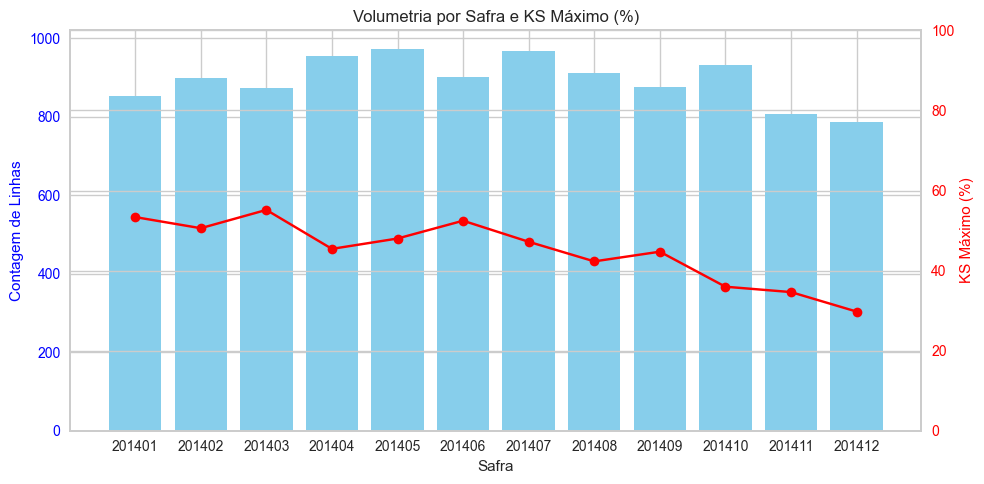

In [25]:
plotar_ks_safra(tabela_ks)

In [26]:
# O que leva nosso modelo a perder performance no OOT?
#Se o modelo perdeu performance no OOT, algumas causas podem ser:
#
#Mudança nos dados – Os padrões dos dados mudaram com o tempo.
#Mudança na relação com a target – As variáveis deixaram de influenciar o resultado da mesma forma.
#Overfitting – O modelo aprendeu muito bem o treino, mas não generaliza para novos períodos.
#Dados desatualizados – O treino foi feito com dados antigos e não reflete a realidade atual.
#Erros no processamento – Alguma transformação nos dados do OOT pode estar errada.
#Fatores externos – Eventos novos afetaram o comportamento dos dados (ex: crise, novas regras).

In [27]:
#Importancia de variáveis non light gbm (quantas vezes a variável foi utilizada para realizar o corte na folha da árvore)
#Os betas (β) na Regressão Logística são os coeficientes que medem o efeito de cada variável independente na probabilidade de um determinado evento ocorrer.

df_lgbm_vars = obter_importancia_variaveis(tuned_lightgbm, "LightGBM")
df_logistica_vars = obter_importancia_variaveis(tuned_lr, "Regressão Logística")

In [30]:
#Se uma variável que é importante para o modelo muda de distribuição, isso pode causar problemas na previsão.

#O p-valor mede a probabilidade de observarmos uma diferença tão grande entre duas amostras apenas por acaso, assumindo que elas vêm da mesma distribuição.
#Se p-valor < 0.05 → Existe menos de 5% de chance de que a diferença seja mero acaso. Ou seja, há evidências estatísticas de que as distribuições são diferentes!
#Se p-valor >= 0.05 → Não há evidências suficientes para afirmar que as distribuições mudaram.
#No caso do KS Test (Kolmogorov-Smirnov), um p-valor < 0.05 indica que a distribuição da variável mudou significativamente entre a safra de referência e a safra atual.

#O PSI (Índice de Estabilidade Populacional) mede a diferença entre duas distribuições.
#Dividimos os dados em faixas de valores, Calculamos as frequências relativas em cada bin para ambas as populações (referência e atual).
#PSI < 0.1 → Pequena diferença (distribuição estável)
#0.1 ≤ PSI < 0.25 → Diferença moderada (monitorar)
#PSI ≥ 0.25 → Diferença significativa (possível problema )


psi,ks = monitorar_variaveis_continuas(pd.concat([train_selecionada,test_oos]), test_oot, [x for x in train_selecionada.columns if x not in ['id','safra','y']])

In [31]:
avaliar_vars_ks = df_lgbm_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [32]:
avaliar_vars = avaliar_vars_ks.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [33]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
train_selecionada['VAR_1'].mean(),test_oos['VAR_1'].mean(),test_oot['VAR_1'].mean()

(35.910627283800245, 34.55386488131467, 21.95211713494262)

In [34]:
avaliar_vars

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta_x,index_y,PSI,Alerta_y
0,VAR_9,113,VAR_9,0.053509,2.984786e-05,Mudança Significativa,NaN,NaN,NaN
1,VAR_1,89,VAR_1,0.112028,1.418061e-21,Mudança Significativa,VAR_1,0.127429,Mudança Moderada
2,VAR_17,53,VAR_17,0.078658,7.566007e-11,Mudança Significativa,NaN,NaN,NaN
3,VAR_6,51,VAR_6,0.031665,4.046303e-02,Mudança Significativa,NaN,NaN,NaN
4,VAR_20,41,VAR_20,0.051645,6.379091e-05,Mudança Significativa,NaN,NaN,NaN
5,VAR_72,37,VAR_72,0.033875,2.307364e-02,Mudança Significativa,NaN,NaN,NaN
6,VAR_65,36,VAR_65,0.039043,5.353067e-03,Mudança Significativa,NaN,NaN,NaN
7,VAR_57,36,VAR_57,0.037672,8.048713e-03,Mudança Significativa,NaN,NaN,NaN
8,VAR_44,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,VAR_76,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
avaliar_vars_ks_lr = df_logistica_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [36]:
avaliar_vars_lr = avaliar_vars_ks_lr.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [37]:
avaliar_vars_lr

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta_x,index_y,PSI,Alerta_y
0,VAR_1,1.053071,VAR_1,0.112028,1.418061e-21,Mudança Significativa,VAR_1,0.127429,Mudança Moderada
1,VAR_9,0.460450,VAR_9,0.053509,2.984786e-05,Mudança Significativa,NaN,NaN,NaN
2,VAR_44,-0.407982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VAR_20,0.378257,VAR_20,0.051645,6.379091e-05,Mudança Significativa,NaN,NaN,NaN
4,VAR_40,0.339001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,VAR_17,-0.253802,VAR_17,0.078658,7.566007e-11,Mudança Significativa,NaN,NaN,NaN
6,VAR_60,-0.209862,VAR_60,0.037672,8.048713e-03,Mudança Significativa,NaN,NaN,NaN
7,VAR_2,-0.154198,VAR_2,0.081091,1.676138e-11,Mudança Significativa,NaN,NaN,NaN
8,VAR_32,-0.153502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,VAR_6,-0.122530,VAR_6,0.031665,4.046303e-02,Mudança Significativa,NaN,NaN,NaN


In [38]:
# Vamos salvar as bases escoradas para podermos avaliar melhor o modelo com métricas que dependem do Limiar de corte

#train_lightgbm_escorado.to_csv("train_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_lightgbm_escorado.to_csv("test_lightgbm_escorado.csv",sep=",",index=False,header=True)
#train_regressao_escorado.to_csv("train_regressao_escorado.csv",sep=",",index=False,header=True)
#test_regressao_escorado.to_csv("test_regressao_escorado.csv",sep=",",index=False,header=True)
#test_oot_lightgbm.to_csv("test_oot_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_oot_regressao.to_csv("test_oot_regressao_escorado.csv",sep=",",index=False,header=True)

In [40]:
bases_nomeadas = {
    "Train - LightGBM": train_lightgbm_escorado,
    "Test - LightGBM": test_lightgbm_escorado,
    "OOT - LightGBM": test_oot_lightgbm,
    "Train - Regressão Logística": train_regressao_escorado,
    "Test - Regressão Logística": test_regressao_escorado,
    "OOT - Regressão Logística": test_oot_regressao
}
calcular_metricas_multiplas(bases_nomeadas, limiar = 0.3)

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,Train - LightGBM,0.7649,0.5691,0.6870,0.6225,0.8272,0.4881,0.6544,1273,964,3751,580
1,Test - LightGBM,0.7292,0.5167,0.6026,0.5563,0.7733,0.3907,0.5467,279,261,919,184
2,OOT - LightGBM,0.7020,0.5466,0.4261,0.4789,0.7103,0.3238,0.4206,346,287,1428,466
3,Train - Regressão Logística,0.7442,0.5384,0.6552,0.5910,0.7961,0.4416,0.5922,1214,1041,3674,639
4,Test - Regressão Logística,0.7334,0.5229,0.6177,0.5663,0.7813,0.4108,0.5627,286,261,919,177
5,OOT - Regressão Logística,0.7012,0.5496,0.3892,0.4557,0.7100,0.3144,0.4200,316,259,1456,496
